In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from lolip.utils import estimate_local_lip_v2
from params import mnistLip, cifarLip, svhnLip, mnistOtherLips, mnistFixLips, cifarOtherLips, svhnFixLips
from params import cifarFixLips, svhnOtherLips, resImgFixLips, cifarCalibration
from utils import params_to_dataframe

auto_var.set_logging_level(0)

In [2]:
from scipy.special import softmax

def get_arch(path):
    return path.split("-")[path.split("-").index('tor')+1]

def get_ds(path):
    return path.split("-")[1]

def predict_real(model, X):
    X = X.transpose(0, 3, 1, 2)
    dataset = data_utils.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    ret = []
    for [x] in loader:
        ret.append(model(x.to('cuda')).detach().cpu().numpy())
    return np.concatenate(ret, axis=0)

def calc_lip(model, X, Xp, top_norm, btm_norm):
    top = np.linalg.norm(predict_real(model, X)-predict_real(model, Xp), ord=top_norm, axis=1)
    down = np.linalg.norm(X.reshape(len(Xp), -1)-Xp.reshape(len(Xp), -1), ord=btm_norm, axis=1)
    return top / (down+1e-6)

def get_lip(model, X, top_norm=2, btm_norm=2, epsilon=1.0):
    lip = estimate_local_lip_v2(model, X, top_norm=top_norm, btm_norm=btm_norm, epsilon=epsilon)
    lip_ = calc_lip(model, X, lip, top_norm=top_norm, btm_norm=btm_norm)
    return lip_

class ModelWrapper():
    def __init__(self, model):
        self.model = model
    def predict_proba(self, X):
        return softmax(predict_real(self.model, X), axis=1)
    def predict_real(self, X):
        return predict_real(self.model, X)
    def predict(self, X):
        return predict_real(self.model, X).argmax(axis=1)
    
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", 'cifar10')

In [11]:
columns = ['trn_acc', 'tst_acc', 'adv_trn_acc', 'adv_tst_acc', 'avg_trn_lip_1', 'avg_tst_lip_1', 'avg_trn_abs', 'avg_tst_abs']
_, _, grid_params, _ = cifarCalibration()()
df = params_to_dataframe(grid_params,
                         columns=columns,
                         result_file_dir="../results/calibration/",
                         logging_level=0)
df['arch'] = df['model'].apply(lambda a: a.split("-")[2])
for name, d in df.groupby(["dataset", "arch"]):
    print(name)
    display(d)

('cifar10', 'WRN_40_10')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,avg_trn_abs,avg_tst_abs,arch
0,pgd,cifar10,0.031,ce-tor-WRN_40_10,inf,0,1.00000,0.8862,NaN,NaN,347.441545,356.456262,0.025000,0.128564,WRN_40_10
1,pgd,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,0.99714,0.7168,NaN,NaN,33.186252,33.265875,0.044773,0.095968,WRN_40_10
2,pgd,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,1.00000,0.8161,NaN,NaN,24.386368,30.786882,0.025000,0.130262,WRN_40_10
3,pgd,cifar10,0.031,strades3ce-tor-WRN_40_10,inf,0,0.99988,0.7998,NaN,NaN,17.299447,27.383890,0.025025,0.135913,WRN_40_10
4,pgd,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,0.99794,0.7834,NaN,NaN,11.143698,19.788508,0.025460,0.128537,WRN_40_10
5,pgd,cifar10,0.031,advce-tor-WRN_40_10,inf,0,0.99982,0.7400,NaN,NaN,16.087958,16.896749,0.026090,0.095896,WRN_40_10
6,pgd,cifar10,0.031,sllrce-tor-WRN_40_10-lrem2,inf,0,1.00000,0.8583,NaN,NaN,77.817010,79.075219,0.025000,0.152339,WRN_40_10


('cifar10', 'tor')


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,avg_trn_abs,avg_tst_abs,arch
7,pgd,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,1.00000,0.9381,NaN,NaN,418.622176,425.708713,0.025032,0.089175,tor
8,pgd,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,0.94904,0.8074,NaN,NaN,28.566197,28.527540,0.090664,0.019215,tor
9,pgd,cifar10,0.031,aug01-stradesce-tor-WRN_40_10,inf,0,0.99760,0.8496,NaN,NaN,25.408692,28.009600,0.037020,0.052307,tor
10,pgd,cifar10,0.031,aug01-strades3ce-tor-WRN_40_10,inf,0,0.99780,0.8555,NaN,NaN,18.052710,22.423004,0.042392,0.036554,tor
11,pgd,cifar10,0.031,aug01-strades6ce-tor-WRN_40_10,inf,0,0.98928,0.8446,NaN,NaN,10.059369,13.048935,0.097561,0.035638,tor
12,pgd,cifar10,0.031,aug01-advce-tor-WRN_40_10-lrem2,inf,0,0.99842,0.8351,NaN,NaN,24.322157,26.230431,0.035614,0.050502,tor
13,pgd,cifar10,0.031,aug01-llrce-tor-WRN_40_10,inf,0,1.00000,0.9248,NaN,NaN,65.973042,70.279050,0.025000,0.072986,tor
14,pgd,cifar10,0.031,aug01-sllrce-tor-WRN_40_10-lrem2,inf,0,1.00000,0.9144,NaN,NaN,91.913977,94.675263,0.025000,0.119081,tor


In [10]:
for name, d in df.groupby(["dataset", "arch"]):
    print(name)
    display(d)

cifar10


,attack,dataset,eps,model,norm,random_seed,trn_acc,tst_acc,adv_trn_acc,adv_tst_acc,avg_trn_lip_1,avg_tst_lip_1,avg_trn_abs,avg_tst_abs
0,pgd,cifar10,0.031,ce-tor-WRN_40_10,inf,0,1.00000,0.8862,NaN,NaN,347.441545,356.456262,0.025000,0.128564
1,pgd,cifar10,0.031,tulipce-tor-WRN_40_10,inf,0,0.99714,0.7168,NaN,NaN,33.186252,33.265875,0.044773,0.095968
2,pgd,cifar10,0.031,stradesce-tor-WRN_40_10,inf,0,1.00000,0.8161,NaN,NaN,24.386368,30.786882,0.025000,0.130262
3,pgd,cifar10,0.031,strades3ce-tor-WRN_40_10,inf,0,0.99988,0.7998,NaN,NaN,17.299447,27.383890,0.025025,0.135913
4,pgd,cifar10,0.031,strades6ce-tor-WRN_40_10,inf,0,0.99794,0.7834,NaN,NaN,11.143698,19.788508,0.025460,0.128537
5,pgd,cifar10,0.031,advce-tor-WRN_40_10,inf,0,0.99982,0.7400,NaN,NaN,16.087958,16.896749,0.026090,0.095896
6,pgd,cifar10,0.031,sllrce-tor-WRN_40_10-lrem2,inf,0,1.00000,0.8583,NaN,NaN,77.817010,79.075219,0.025000,0.152339
7,pgd,cifar10,0.031,aug01-ce-tor-WRN_40_10,inf,0,1.00000,0.9381,NaN,NaN,418.622176,425.708713,0.025032,0.089175
8,pgd,cifar10,0.031,aug01-tulipce-tor-WRN_40_10,inf,0,0.94904,0.8074,NaN,NaN,28.566197,28.527540,0.090664,0.019215
9,pgd,cifar10,0.031,aug01-stradesce-tor-WRN_40_10,inf,0,0.99760,0.8496,NaN,NaN,25.408692,28.009600,0.037020,0.052307


In [99]:
def get_proba_list(pred, y, bin_counts=10):
    pred_proba = pred.max(axis=1)
    pred_y = pred.argmax(axis=1)
    print("accuracy: ", (pred_y == y).mean())
    print("proba dist: ", np.histogram(pred_proba, bins=np.arange(bin_counts+1)/bin_counts)[0])
    acc_list = []
    err_list = []
    for i in range(bin_counts):
        proba_range = [i/bin_counts, (i+1)/bin_counts]
        idx = np.where(np.logical_and(pred_proba >= proba_range[0], pred_proba < proba_range[1]))[0]
        if len(idx) > 0:
            acc_list.append((pred_y[idx] == y[idx]).mean())
            err_list.append((pred_y[idx] == y[idx]).std())
        else:
            acc_list.append(0.)
            err_list.append(0.)
    return acc_list, err_list

def get_proba_list_fig(proba_list):
    bin_counts = len(proba_list)
    ideal = np.arange(bin_counts) / bin_counts + 1 / 2 / bin_counts
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.bar(x, proba_list)
    
    plt.bar(np.arange(bin_counts), proba_list, label="model")
    plt.bar(np.arange(bin_counts), x, alpha = 0.6, label="ideal")
    plt.show()
    
def calc_calibrate_err(proba_list):
    pass


accuracy:  0.8862
proba dist:  [   0    0    0    0    0    0    1    7   15   25   78   84   75   78
   75   86  127  148  251 8950]


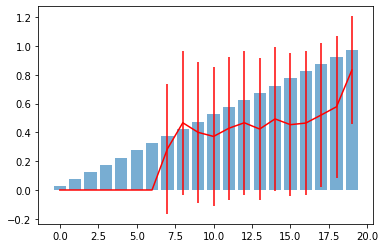

In [101]:
bin_counts = 20
ideal = np.arange(bin_counts) / bin_counts + 1 / 2 / bin_counts
model_path = "../models/pgd-cifar10-0.031-ce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
tst_pred = model.predict_proba(tstX)
proba_list, err_list = get_proba_list(tst_pred, tsty, bin_counts=bin_counts)
plt.errorbar(np.arange(bin_counts), proba_list, yerr=err_list, color="red")
plt.bar(np.arange(bin_counts), ideal, alpha = 0.6)
plt.savefig("./figs/calibration/cifa10_woaug_nat.png")

accuracy:  0.74
proba dist:  [   0    0    0    0    4   23   79  189  243  310  362  399  393  379
  368  418  458  600  816 4959]


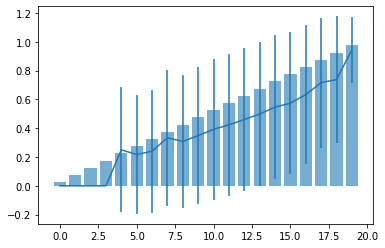

In [102]:
bin_counts = 20
ideal = np.arange(bin_counts) / bin_counts + 1 / 2 / bin_counts
model_path = "../models/pgd-cifar10-0.031-advce-tor-WRN_40_10-inf-0.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()
model = ModelWrapper(model)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
tst_pred = model.predict_proba(tstX)
proba_list, err_list = get_proba_list(tst_pred, tsty, bin_counts=bin_counts)
plt.errorbar(np.arange(bin_counts), proba_list, yerr=err_list)
plt.bar(np.arange(bin_counts), ideal, alpha = 0.6, )
plt.savefig("./figs/calibration/cifa10_woaug_adv.png")

accuracy:  0.8019
proba dist:  [  0   0   0   2  65 240 391 524 511 521 504 486 423 416 429 433 470 545
 744]


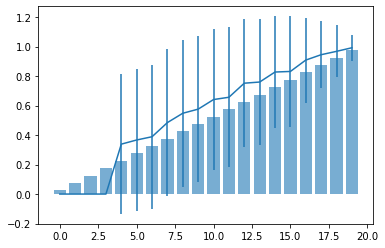

In [90]:
bin_counts = 20
ideal = np.arange(bin_counts) / bin_counts + 1 / 2 / bin_counts
model_path = "../models/pgd-cifar10-0.031-aug01-advce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", get_ds(model_path))
tst_pred = model.predict_proba(tstX)
proba_list, err_list = get_proba_list(tst_pred, tsty, bin_counts=bin_counts)
plt.errorbar(np.arange(bin_counts), proba_list, yerr=err_list)
plt.bar(np.arange(bin_counts), ideal, alpha = 0.6, )
plt.savefig("./figs/calibration/cifa10_adv.png")

accuracy:  0.9381
proba dist:  [  0   0   0   0   0   0   0   4   3  13  41  38  52  33  53  56  69  73
 140]


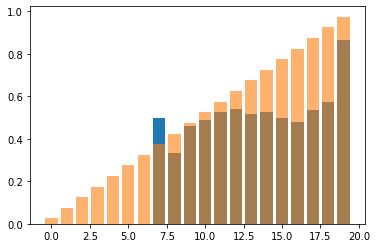

In [86]:
model_path = "../models/pgd-cifar10-0.031-aug01-ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty, bin_counts=bin_counts)
plt.errbar(np.arange(bin_counts), proba_list)
plt.bar(np.arange(bin_counts), ideal, alpha = 0.6)
plt.savefig("./figs/calibration/cifa10_nat.png")

accuracy:  0.8446
proba dist:  [  0   0   0   1  14  95 168 274 306 353 375 357 349 393 434 449 503 512
 671]


<BarContainer object of 20 artists>

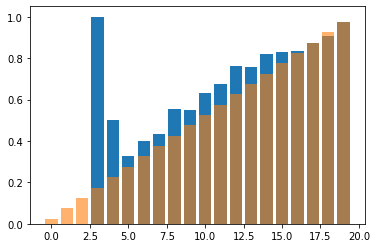

In [85]:
model_path = "../models/pgd-cifar10-0.031-aug01-strades6ce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty, bin_counts=bin_counts)
plt.bar(np.arange(bin_counts), proba_list)
plt.bar(np.arange(bin_counts), ideal, alpha = 0.6)
plt.savefig("./figs/calibration/cifa10_nat.png")

accuracy:  0.8496
proba dist:  [  0   0   9  99 267 450 403 455 697]


<BarContainer object of 10 artists>

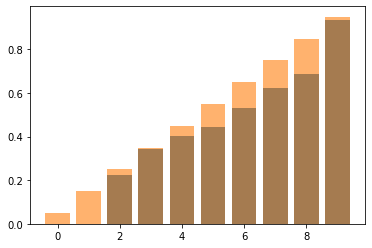

In [76]:
model_path = "../models/pgd-cifar10-0.031-aug01-stradesce-tor-WRN_40_10-inf-0-ep0120.pt"
model = globals()[get_arch(model_path)](n_classes=10)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()
model.cuda()
model = ModelWrapper(model)
tst_pred = model.predict_proba(tstX)
proba_list = get_proba_list(tst_pred, tsty)
plt.bar(np.arange(10), proba_list)
plt.bar(np.arange(10), np.arange(10)/10+0.05, alpha = 0.6)